# Total variation in-painting

A color image is represented as an $m \times n \times 3$ matrix of RGB values
$U^\mathrm{orig}$ (typically between the values $0$ and $255$).
We are given the pixels $U^\mathrm{orig}_{ij}$, for $(i,j) \in \mathcal K$, where
$\mathcal K \subset \{1,\ldots, m\} \times \{1, \ldots, n\}$ is the set of indices
corresponding to known pixels. Each pixel $U^\mathrm{orig}_{ij}$ is a vector in ${\bf R}^3$ of RGB values.
Our job is to *in-paint* the image by guessing the missing pixels,
*i.e.*, those with indices not in $\mathcal K$.
The reconstructed image will be represented by $U \in {\bf R}^{m \times n \times 3}$,
where $U$ matches the known pixels, *i.e.*,
$U_{ij} = U^\mathrm{orig}_{ij}$ for $(i,j) \in \mathcal K$.

The reconstruction $U$ is found by minimizing the total variation of $U$,
subject to matching the known pixel values. We will use the $\ell_2$ total
variation, defined as
$$\mathop{\bf tv}(U) =
\sum_{i=1}^{m-1} \sum_{j=1}^{n-1}
\left\| \left[ \begin{array}{c}
 U_{i+1,j}-U_{ij}\\ 
 U_{i,j+1}-U_{ij} 
 \end{array} \right] \right\|_2.$$
Note that the norm of the discretized gradient is *not* squared.

We load the original image and construct the Known matrix by randomly selecting 30% of the pixels to keep and discarding the others. The original and corrupted images are displayed below. The corrupted image has the missing pixels blacked out.

In [1]:
# Generate/load data for in-painting problem.
from PIL import Image
import numpy as np

PROB_PIXEL_LOST = 0.8

np.random.seed(1)
# Load the images.
orig_img = Image.open("lena512color.tiff")

# Convert to arrays.
Xorig = np.array(orig_img)
rows, cols, colors = Xorig.shape

# K is 1 if the pixel is known,
# 0 if the pixel was corrupted.
# The K matrix is initialized randomly.
K = np.zeros((rows, cols, colors))
for i in range(rows):
    for j in range(cols):
        if np.random.random() > PROB_PIXEL_LOST:
            for k in range(colors):
                K[i, j, k] = 1
n = rows
known = np.hstack([np.reshape(K[:,:,i], (n*n,1)) for i in range(colors)])
known = known.astype(bool)

Xcorr = K*Xorig
corr_img = Image.fromarray(np.uint8(Xcorr))
RGB = np.hstack([np.reshape(Xcorr[:,:,i], (n*n,1)) for i in range(colors)])

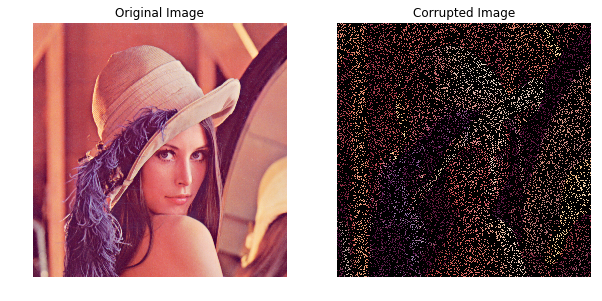

In [2]:
# Display the images.
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(1, 2,figsize=(10, 5))
ax[0].imshow(orig_img)
ax[0].set_title("Original Image")
ax[0].axis('off')
ax[1].imshow(corr_img)
ax[1].set_title("Corrupted Image")
ax[1].axis('off')
plt.show()

We express the total variation color in-painting problem in CVXPY using three matrix variables (one for the red values, one for the blue values, and one for the green values). We use the solver SCS, which finds the optimal value in 25 seconds. The solvers ECOS and CVXOPT don't scale to this large problem.

In [3]:
# Recover the original image using total variation in-painting.
# WARNING: may take several minutes to run.
import cvxpy as cvx

R, G, B = cvx.Variable((n, n)), cvx.Variable((n, n)), cvx.Variable((n, n))
X = cvx.vstack((cvx.vec(R), cvx.vec(G), cvx.vec(B))).T
prob = cvx.Problem(cvx.Minimize(cvx.tv(R,G,B)),
                   [X[known] == RGB[known],
                    0 <= X, X <= 255])
prob.solve(solver=cvx.SCS, verbose=True)

----------------------------------------------------------------------------
	SCS v1.2.6 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2016
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 5124382, CG tol ~ 1/iter^(2.00)
eps = 1.00e-03, alpha = 1.50, max_iters = 2500, normalize = 1, scale = 1.00
Variables n = 1047553, constraints m = 3557656
Cones:	primal zero / dual free vars: 156945
	linear vars: 1572864
	soc vars: 1827847, soc blks: 261121
Setup time: 6.88e-01s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 2.01e+01  1.86e+01  1.00e+00 -1.54e+09  3.52e+07  6.54e-07  3.24e+00 
   100| 4.68e-03  7.11e-03  2.54e-02  2.20e+06  2.31e+06  1.95e-08  6.11e+01 
   200| 1.19e-03  9.33e-04  6.23e-03  2.38e+06  2

2422326.575439855

After solving the problem, the RGB values of the in-painted image are stored in the value fields of the three variables. We display the in-painted image and the difference in RGB values at each pixel of the original and in-painted image. Though the in-painted image looks almost identical to the original image, you can see that many of the RGB values differ.

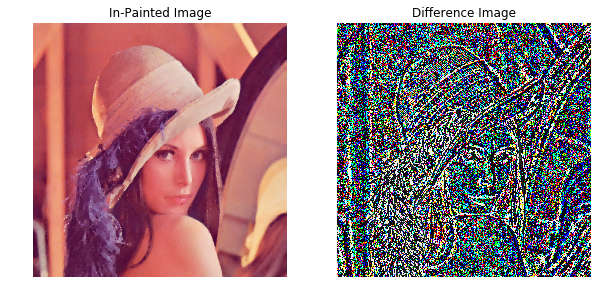

In [4]:
# Plot the in-painted image.
import matplotlib.cm as cm

# Load variable values into a single array.
rec_arr = np.zeros((rows, cols, colors), dtype=np.uint8)
variables = [R, G, B]
for i in range(colors):
    rec_arr[:, :, i] = variables[i].T.value

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# Display the in-painted image.
img_rec = Image.fromarray(rec_arr)
ax[0].imshow(img_rec);
ax[0].set_title("In-Painted Image")
ax[0].axis('off')

# Display the difference between the original image and the in-painted image.
img_diff = Image.fromarray(np.abs(Xorig - rec_arr))
ax[1].imshow(img_diff);
ax[1].set_title("Difference Image")
ax[1].axis('off');

plt.show()